# Anomaly Detection
Anomaly Detection이란 일반적으로 정상 데이터로 학습하여 **정상 데이터가 아닌 데이터**를 탐지하는 방법론을 의미한다. 이때, 일반적인 분류 태스크와 달리 정상/비정상의 구분이 명확하지 않다는 특징을 가지고 있다. 즉, 모델을 학습하거나, 파라미터를 추론하는 시점에서 비정상 데이터가 가지는 특징 혹은 분포를 알 수 없다고 가정한다. 이 상황에서 가장 중요한 점은 정상 데이터를 정의하고, 이를 바탕으로 모델을 학습하여, 모델이 학습하지 못한 분포에서 생성되었다고 간주할 수 있는 데이터가 입력되었을 때, 이를 탐지할 수 있어야 한다. 

이번에는 다양한 Anomaly Detection 방법론 중에 AutoEncoder를 이용하여 여러가지 실험을 진행해보자. AutoEncoder란 아래 그림과 같이 Input과 Output이 동일하고, 모델 구조가 대칭적인 형태를 지니는 모델을 의미한다. 이러한 모델 구조로 인해 AutoEncoder는 다음과 같은 특징을 가진다. 

<figure class="half">
    <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png" title="SVM" height="200">
<figure>
이미지 출처 : https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f




1. 모델이 입력된 데이터를 임의의 Hidden Representation으로 압축하였다가, 이를 다시 복원하여 원본 데이터를 만들도록 하는 특징을 가지고 있다. 
2. 차원 축소 방법론으로서 잘 학습된 모델이 생성하는 Hidden Representation은 원본 데이터의 특징을 잘 표현하고 있다고 간주할 수 있다. 
3. Anomaly Detection에 사용 시 복원된 이미지가 원본 이미지와 발생하는 차이를 이용하여 Anomaly Score를 산출할 수 있다. 

3과 같은 특징을 가지는 이유는 AutoEncoder는 학습된 데이터만 잘 복원할 수 있다. 이로 인해 학습된 데이터와 다른 분포를 가지는 데이터 즉, **정상 데이터가 아닌 데이터**의 경우 잘 복원하지 못하게 된다. 이는 결국 Anomaly에 대해 오차가 커지게 되고, 이를 직접 Anomaly Score로 활용할 수 있는 것이다. 

#### 특히 이번 실험에서 AutoEncoder의 가장 큰 특징인 원본 이미지의 복원 성능과 Anomaly Detection 성능이 일치하지 않는다는 결론을 도출하기 위한 여러가지 실험을 진행할 것이다. 이는 일반화 성능이 항상 좋다는 직관과 대비되는 결론으로 어떻게 이러한 결론이 도출될 수 있는지 살펴보자. 

In [1]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


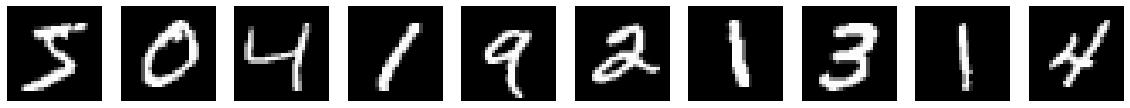

In [2]:
fig, axs =  plt.subplots(1, 10, figsize=(20, 5))
train_dataset = datasets.MNIST(root='/project/codes/business_analytics', train=True, transform=transforms.ToTensor())
for i in range(10):
    axs[i].imshow(train_dataset[i][0].reshape(28, 28), cmap='gray')
    axs[i].axis('off')

In [3]:
class AutoEncoder(torch.nn.Module) :
    def __init__(self, model_args):
        super(AutoEncoder, self).__init__()
        self.model_args = model_args
        self.gaussian_noise_mag = model_args.gaussian_noise_mag
        self.down_projection_layers = [torch.nn.Linear(model_args.hidden_sizes[i], model_args.hidden_sizes[i+1]) for i in range(len(model_args.hidden_sizes)-1)]
        self.up_projection_layers = [torch.nn.Linear(model_args.hidden_sizes[::-1][i], model_args.hidden_sizes[::-1][i+1]) for i in range(len(model_args.hidden_sizes)-1)]

        encoder_modules = []
        for layer in self.down_projection_layers:
            encoder_modules.append(layer)
            encoder_modules.append(torch.nn.ReLU())
        self.encoder = torch.nn.Sequential(*encoder_modules)

        decoder_modules = []
        for idx, layer in enumerate(self.up_projection_layers) :
            decoder_modules.append(layer)
            if idx < len(self.up_projection_layers)-1:
                decoder_modules.append(torch.nn.ReLU())
            else :
                decoder_modules.append(torch.nn.Sigmoid()) # output layer는 sigmoid 함수를 사용
        self.decoder = torch.nn.Sequential(*decoder_modules)

    def forward(self, x):
        if (self.model_args.add_gaussian_noise) and (self.train) : # train mode일 때만 gaussian noise를 추가
            x = self.add_gaussian_noise(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def add_gaussian_noise(self, x):
        return x + (0.1*self.gaussian_noise_mag)*torch.randn(x.shape)

In [4]:
# model_args 클래스
class ModelArgs:
    def __init__(self):
        self.hidden_sizes = [784, 256, 64] # hidden layer의 노드 개수
        self.add_gaussian_noise = False # 입력에 가우시안 노이즈를 추가할지 여부
        self.gaussian_noise_mag = 0.1 # 가우시안 노이즈의 크기

# train_args 클래스 
class TrainArgs:
    def __init__(self):
        self.epochs = 10 # epoch 수
        self.lr = 0.01 # learning rate
        self.max_steps = 10000

class DataArgs :
    def __init__(self):
        self.normal_class = {0, 1, 2, 3, 4} 

# main 함수
class Trainer :
    def __init__(self, model_args, train_args, data_args = None):
        self.model_args = model_args
        self.train_args = train_args
        
        self.model = AutoEncoder(model_args)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=train_args.lr)
        self.criterion = torch.nn.MSELoss()
        self.criterion_for_anomaly_score = torch.nn.MSELoss(reduction = "none")

        self.train_dataset = datasets.MNIST(root='/project/codes/business_analytics', train=True, transform=transforms.ToTensor(), download=True)
        self.test_dataset = datasets.MNIST(root='/project/codes/business_analytics', train=False, transform=transforms.ToTensor())
        self.test_dataset_dict = {j : torch.utils.data.Subset(self.test_dataset, [i for i in range(len(self.test_dataset)) if self.test_dataset[i][1] == j]) for j in range(10)}

        if data_args is not None:
            self.train_dataset = torch.utils.data.Subset(self.train_dataset, [i for i in range(len(self.train_dataset)) if self.train_dataset[i][1] in data_args.normal_class])

        self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=64, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset, batch_size=64, shuffle=False)

    def train(self):
        self.step = 0
        self._train()

    def infer_anomaly_score(self) :
        self.model.eval()
        anomaly_score = []
        with torch.no_grad():
            for data, _ in self.test_loader:
                data = data.view(-1, 784)
                encoded, decoded = self.model(data)
                anomaly_score.append(self.criterion_for_anomaly_score(decoded, data).sum(axis = 1).tolist())
        return anomaly_score

    def visualize(self) :
        fig, axs =  plt.subplots(2, 10, figsize=(20, 4))
        axs[0][0].set_ylabel("real test image")
        axs[1][0].set_ylabel("decoded test image")
        for i in range(10):
            with torch.no_grad() :
                data, _ = self.test_dataset_dict[i][0]
                axs[0][i].imshow(data.view(28, 28).numpy(), cmap='gray', aspect = "auto")
                data = data.view(-1, 784)
                _, decoded = self.model(data)
                axs[1][i].imshow(decoded.view(28, 28).numpy(), cmap='gray', aspect = "auto")

        # train 함수
    def _train(self):
        self.model.train()
        while self.step < self.train_args.max_steps:
            for data, _ in self.train_loader: # autoencoder는 label이 필요없음
                data = data.view(-1, 784)
                self.optimizer.zero_grad()
                encoded, decoded = self.model(data)
                loss = self.criterion(decoded, data)
                loss.backward()
                self.optimizer.step()
                self.step += 1
                if self.step % 5000 == 0:
                    print(f'Train step: {self.step} \tLoss: {loss:.6f}', end='\r')
        self.final_test_loss = self._test()

    # test 함수
    def _test(self):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in self.test_loader:
                data = data.view(-1, 784)
                _, decoded = self.model(data)
                test_loss += self.criterion(decoded, data)
        test_loss /= len(self.test_loader.dataset)
        print('====> Test set loss: {:.6f}'.format(test_loss), end='\r')
        return test_loss

## 1. 기본적인 AutoEncoder 실험

In [5]:
simple_exp_trainer_dict = {}

### 1-1. 단순 AutoEncoder

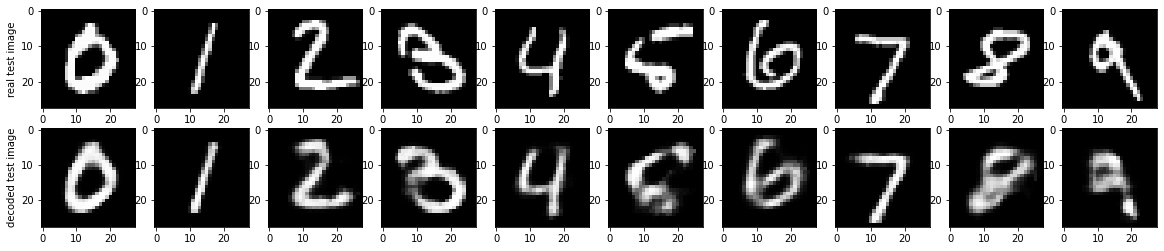

In [6]:
model_args = ModelArgs()
train_args = TrainArgs()
trainer_base = Trainer(model_args, train_args)
trainer_base.train()
trainer_base.visualize()
simple_exp_trainer_dict["base"] = trainer_base

### 1-2. 얕은 AutoEncoder

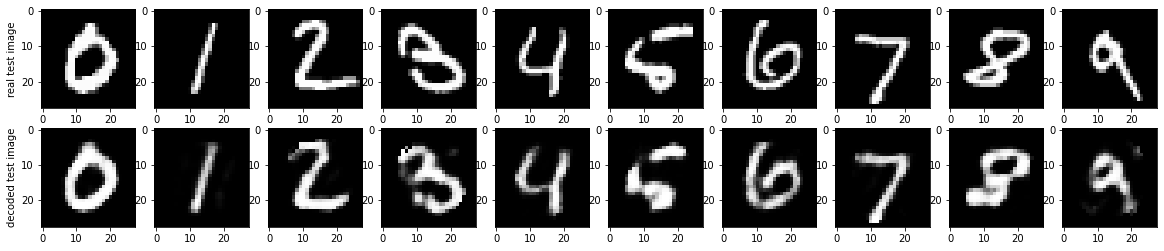

In [7]:
model_args = ModelArgs()
model_args.hidden_sizes = [784, 64]
train_args = TrainArgs()
trainer_shallow = Trainer(model_args, train_args)
trainer_shallow.train()
trainer_shallow.visualize()
simple_exp_trainer_dict["shallow"] = trainer_shallow

**AutoEncoder의 레이어 수를 다르게 하여 실험을 진행한 결과, hidden layer가 2개일 때(0.000289)보다 하나일 경우(0.000184)가 더 좋은 성능을 보이는 것으로 나타났다. 이는 데이터 수가 제한적(약 60,000개)이고, 태스크가 비교적 단순(흑백 이미지)하므로 학습 파라미터가 적은 모델이 유리하기 때문으로 해석된다. 이후 실험은 모두 hidden layer가 적은 shallow AutoEncoder로 진행할 예정이다**

### 1-3. Denoising AutoEncoder

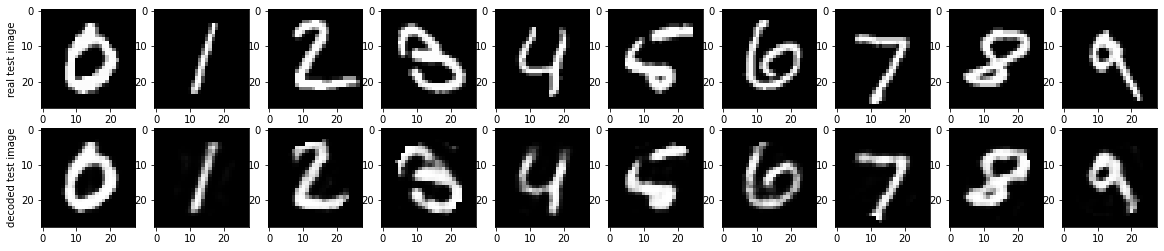

In [8]:
model_args = ModelArgs()
model_args.add_gaussian_noise = True
model_args.hidden_sizes = [784, 64]
train_args = TrainArgs()
trainer_base_denoise0_1 = Trainer(model_args, train_args)
trainer_base_denoise0_1.train()
trainer_base_denoise0_1.visualize()
simple_exp_trainer_dict["denoise0_1"] = trainer_base_denoise0_1

**AutoEncoder에 noise를 주입하고, 이를 원본 이미지로 복원하도록 학습하는 Denoising AutoEncoder 실험결과 noise를 삽입하지 않은 경우에 더 높은 성능을 보이는 것으로 나타낫다. 하지만, 이는 노이즈의 강도가 너무 강하여 원본 이미지의 정보가 많이 손실되었기 때문으로 보고, 노이즈를 줄여 다시 실험을 진행하였다.**

### 1-4. Denoising AutoEncoder with low Gaussian noise

In [9]:
model_args = ModelArgs()
model_args.add_gaussian_noise = True
model_args.gaussian_noise_mag = 0.01
model_args.hidden_sizes = [784, 64]
train_args = TrainArgs()
trainer_base_denoise0_01 = Trainer(model_args, train_args)
trainer_base_denoise0_01.train()
simple_exp_trainer_dict["denoise0_01"] = trainer_base_denoise0_01

**noise의 강도를 줄인 결과도 큰 차이가 없었다. 향후 실험에서 Anomaly Detection task에서 Noise 강도에 따른 실험을 추가적으로 진행해보자**

### 1-5. Simple Experiments Results

In [10]:
import pandas as pd
result_pd = pd.DataFrame({
    "methods" : [i for i in simple_exp_trainer_dict.keys()],
    "test_loss" : [simple_exp_trainer_dict[i].final_test_loss for i in simple_exp_trainer_dict.keys()]
    })
display(result_pd)

,methods,test_loss
0,base,tensor(0.0003)
1,shallow,tensor(0.0002)
2,denoise0_1,tensor(0.0002)
3,denoise0_01,tensor(0.0002)


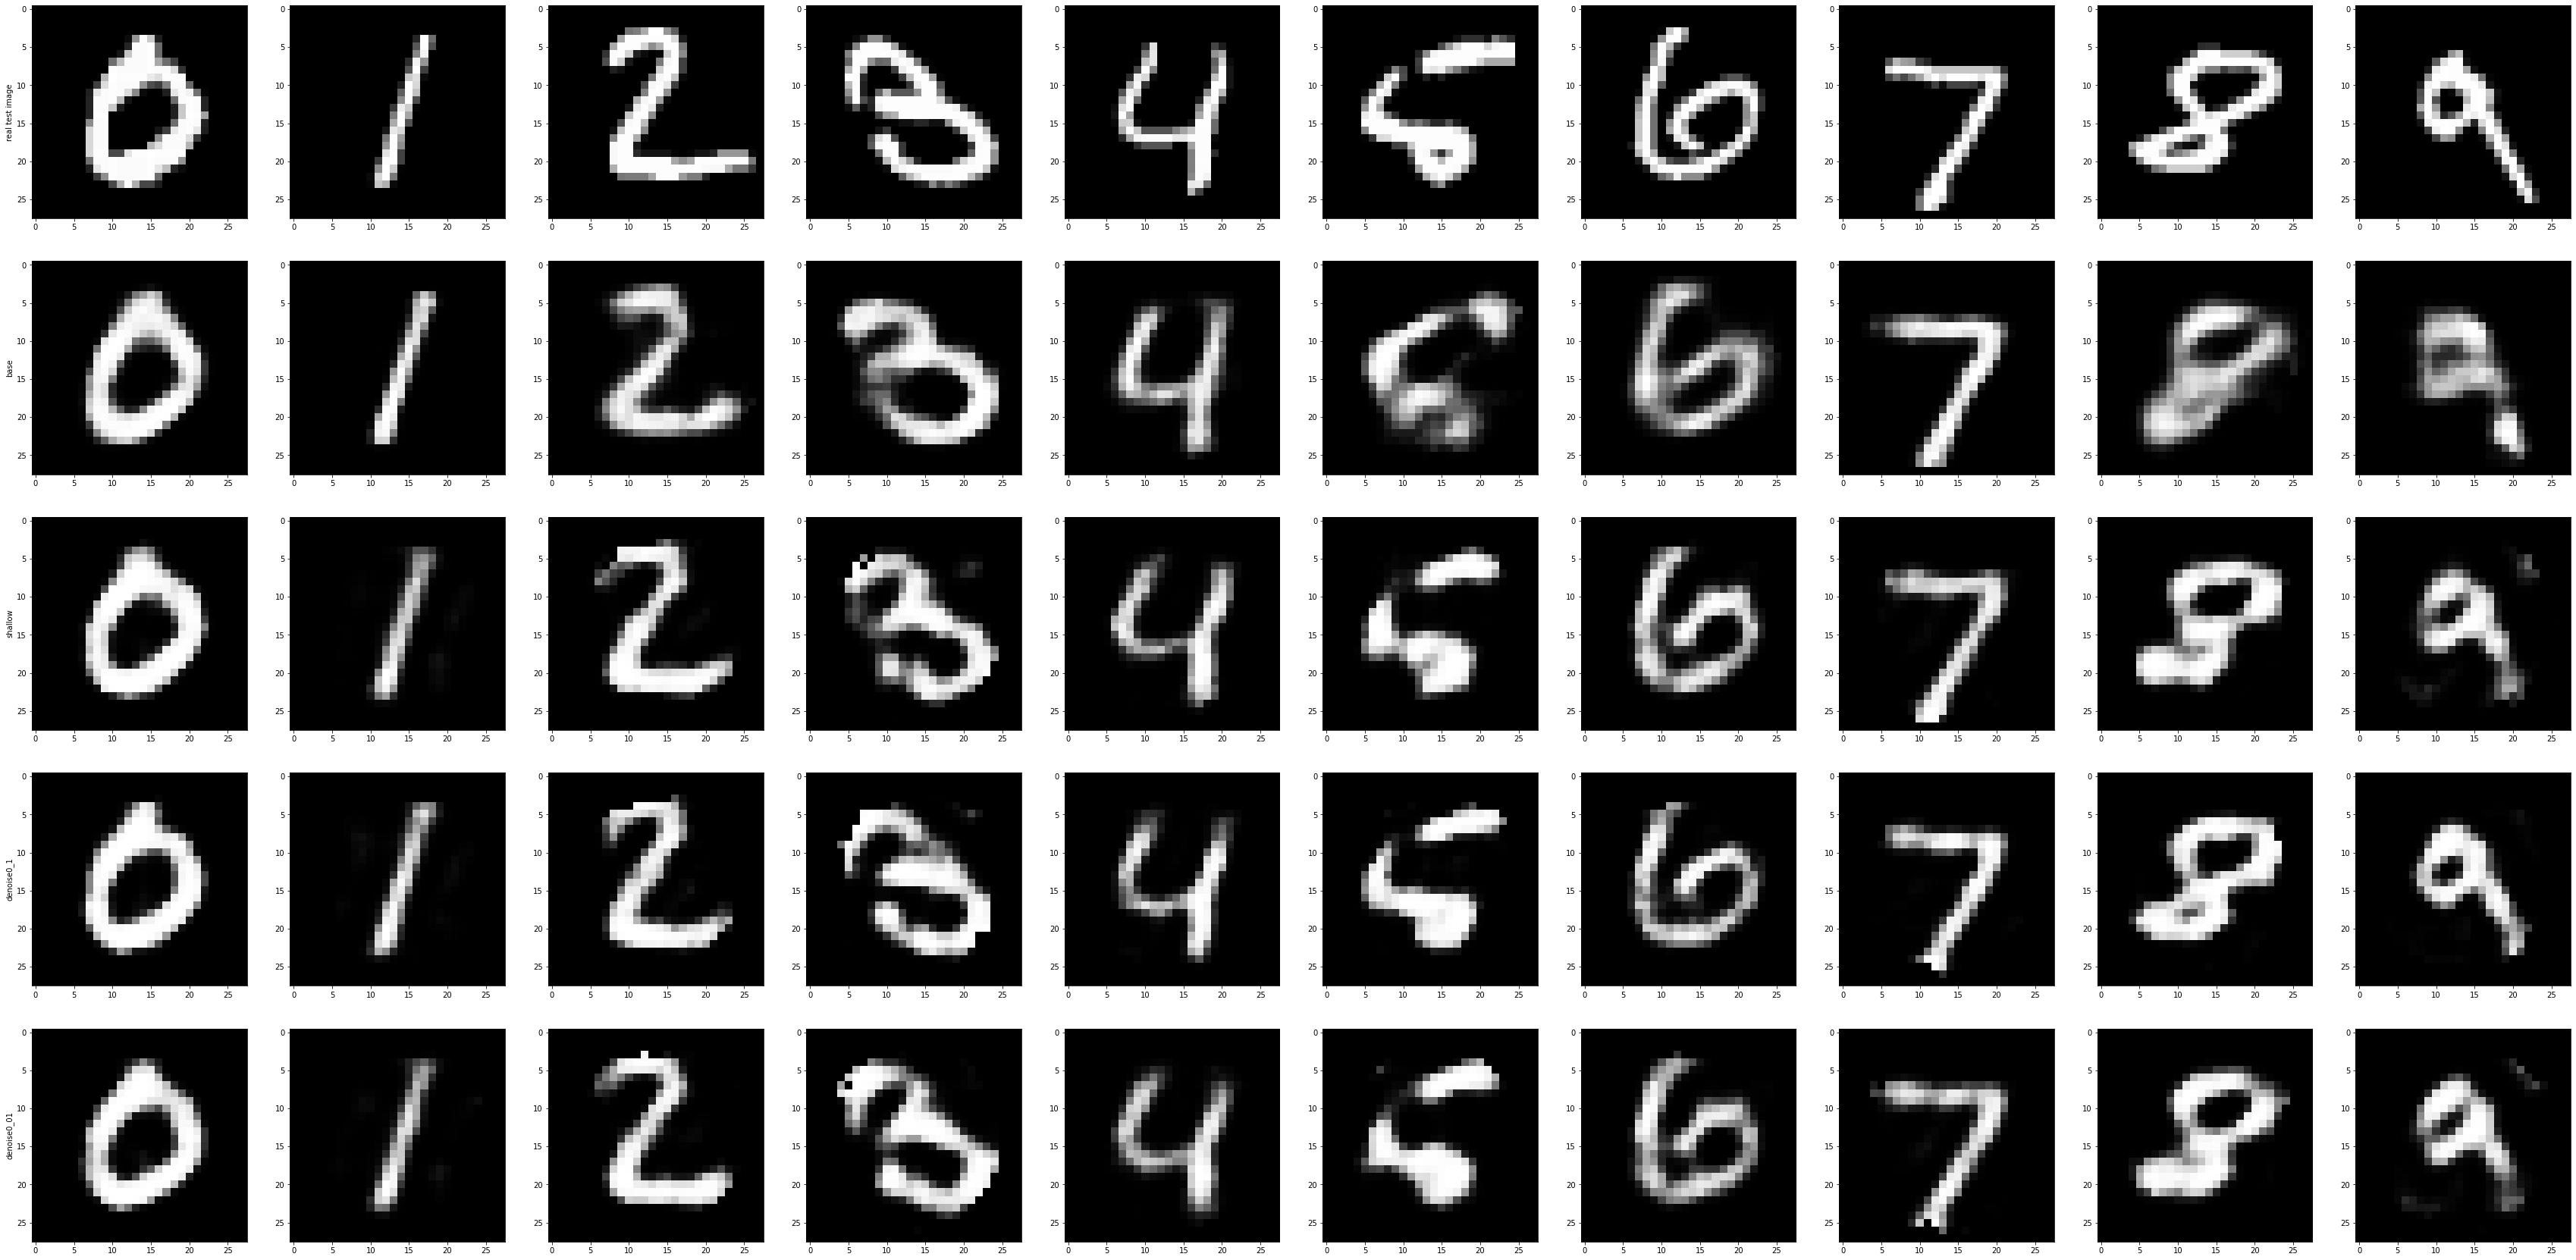

In [11]:
# visualization
fig, axs =  plt.subplots(len(simple_exp_trainer_dict.keys()) + 1, 10, figsize=(60, 30))
axs[0][0].set_ylabel("real test image")
for i in range(10):
    axs[0][i].imshow(simple_exp_trainer_dict["base"].test_dataset_dict[i][0][0].view(28, 28).numpy(), cmap='gray', aspect = "auto")

for idx, (name, methods) in enumerate(simple_exp_trainer_dict.items()):
    for i in range(10):
        with torch.no_grad() :
            axs[idx+1][0].set_ylabel(name)
            data, _ = methods.test_dataset_dict[i][0]
            data = data.view(-1, 784)
            _, decoded = methods.model(data)
            axs[idx+1][i].imshow(decoded.view(28, 28).numpy(), cmap='gray', aspect = "auto")


**단순 Denoising AutoEncoder에 대한 실험을 정리하면 위와 같다. loss에서 나온 양상과 비슷하게, denoising AutoEncoder의 경우 또렷한 윤곽을 생성해내지만, 단순 AutoEncoder의 경우 윤곽이 흐릿한 것을 알 수 있다. 하지만 노이즈의 강도에 따른 유의미한 차이를 볼 수 없다.**

# 2. Anomaly Detection 실험 1 : Abnormal Data의 분포는 유지한채, Normal 데이터 분포를 변화)

다음 실험은 정상 데이터의 분포를 줄이면서, 비정상 데이터의 분포를 유지할 경우 성능이 어떻게 변화하는지 관찰하기 위한 실험이다. 
이를 위해 정상 데이터의 분포를 점차 줄이면서 AUROC 성능을 측정할 것이다. 
이때, 모델 학습을 동일하게 진행하기 위해 step 을 10,000으로 고정하고, 정상 데이터 클래스인 0, 1, 2, 3, 4를 모두 정상으로 간주하였다. 
이로인해, 일부 정상 데이터 클래스에 대해 학습하지 못한 모델의 성능이 급격히 떨어질 수 있으나, 이는 실제 상황에 대한 가정이다. 자세한 해석은 아래 결과를 통해 살펴보자

### 2-1. Case 1
- Normal Data : 0 ~ 4
- Abnormal Data : 5 ~ 9

In [12]:
anomaly_model_dict = {}
anomaly_score_dict = {}

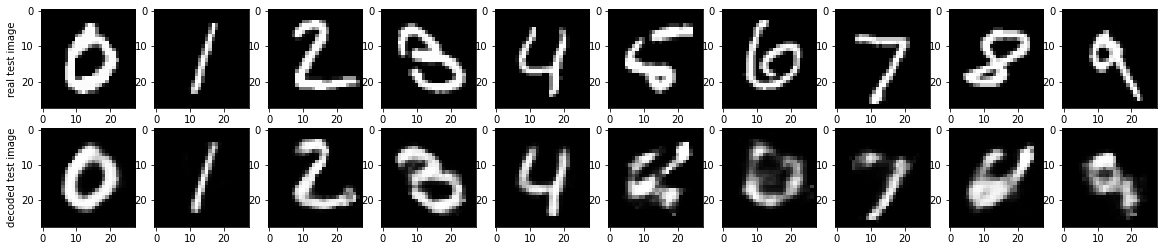

In [13]:
model_args = ModelArgs()
train_args = TrainArgs()
data_args = DataArgs()
trainer_half = Trainer(model_args, train_args, data_args)
trainer_half.train()
trainer_half.visualize()
anomaly_model_dict["0-4"] = trainer_half

### 2-2. Case 2
- Normal Data : 0 ~ 1
- Abnormal Data : 5 ~9

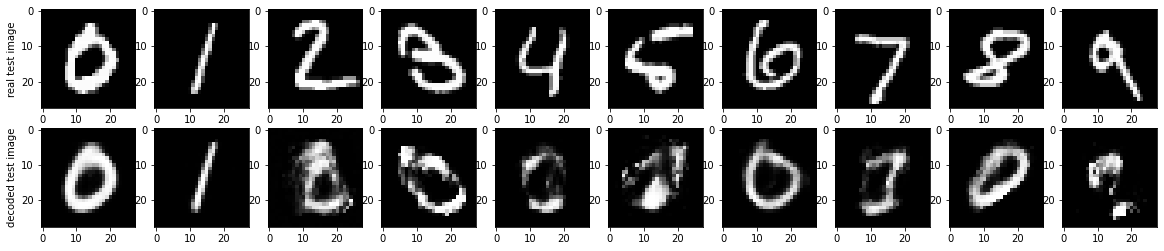

In [14]:
model_args = ModelArgs()
train_args = TrainArgs()
data_args = DataArgs()
data_args.normal_class = {0, 1} # batch size
trainer_01 = Trainer(model_args, train_args, data_args)
trainer_01.train()
trainer_01.visualize()
anomaly_model_dict["0-1"] = trainer_01

### 2-3. Case 3
- Normal Data : 0
- Abnormal Data : 5 ~ 9

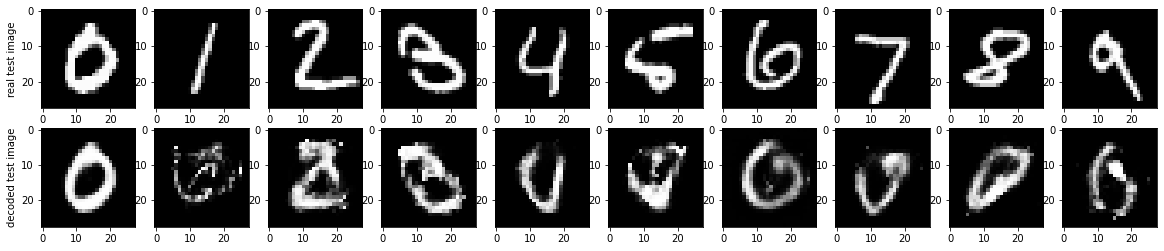

In [15]:
model_args = ModelArgs()
train_args = TrainArgs()
data_args = DataArgs()
data_args.normal_class = {0}
trainer_0 = Trainer(model_args, train_args, data_args)
trainer_0.train()
trainer_0.visualize()
anomaly_model_dict["0"] = trainer_0

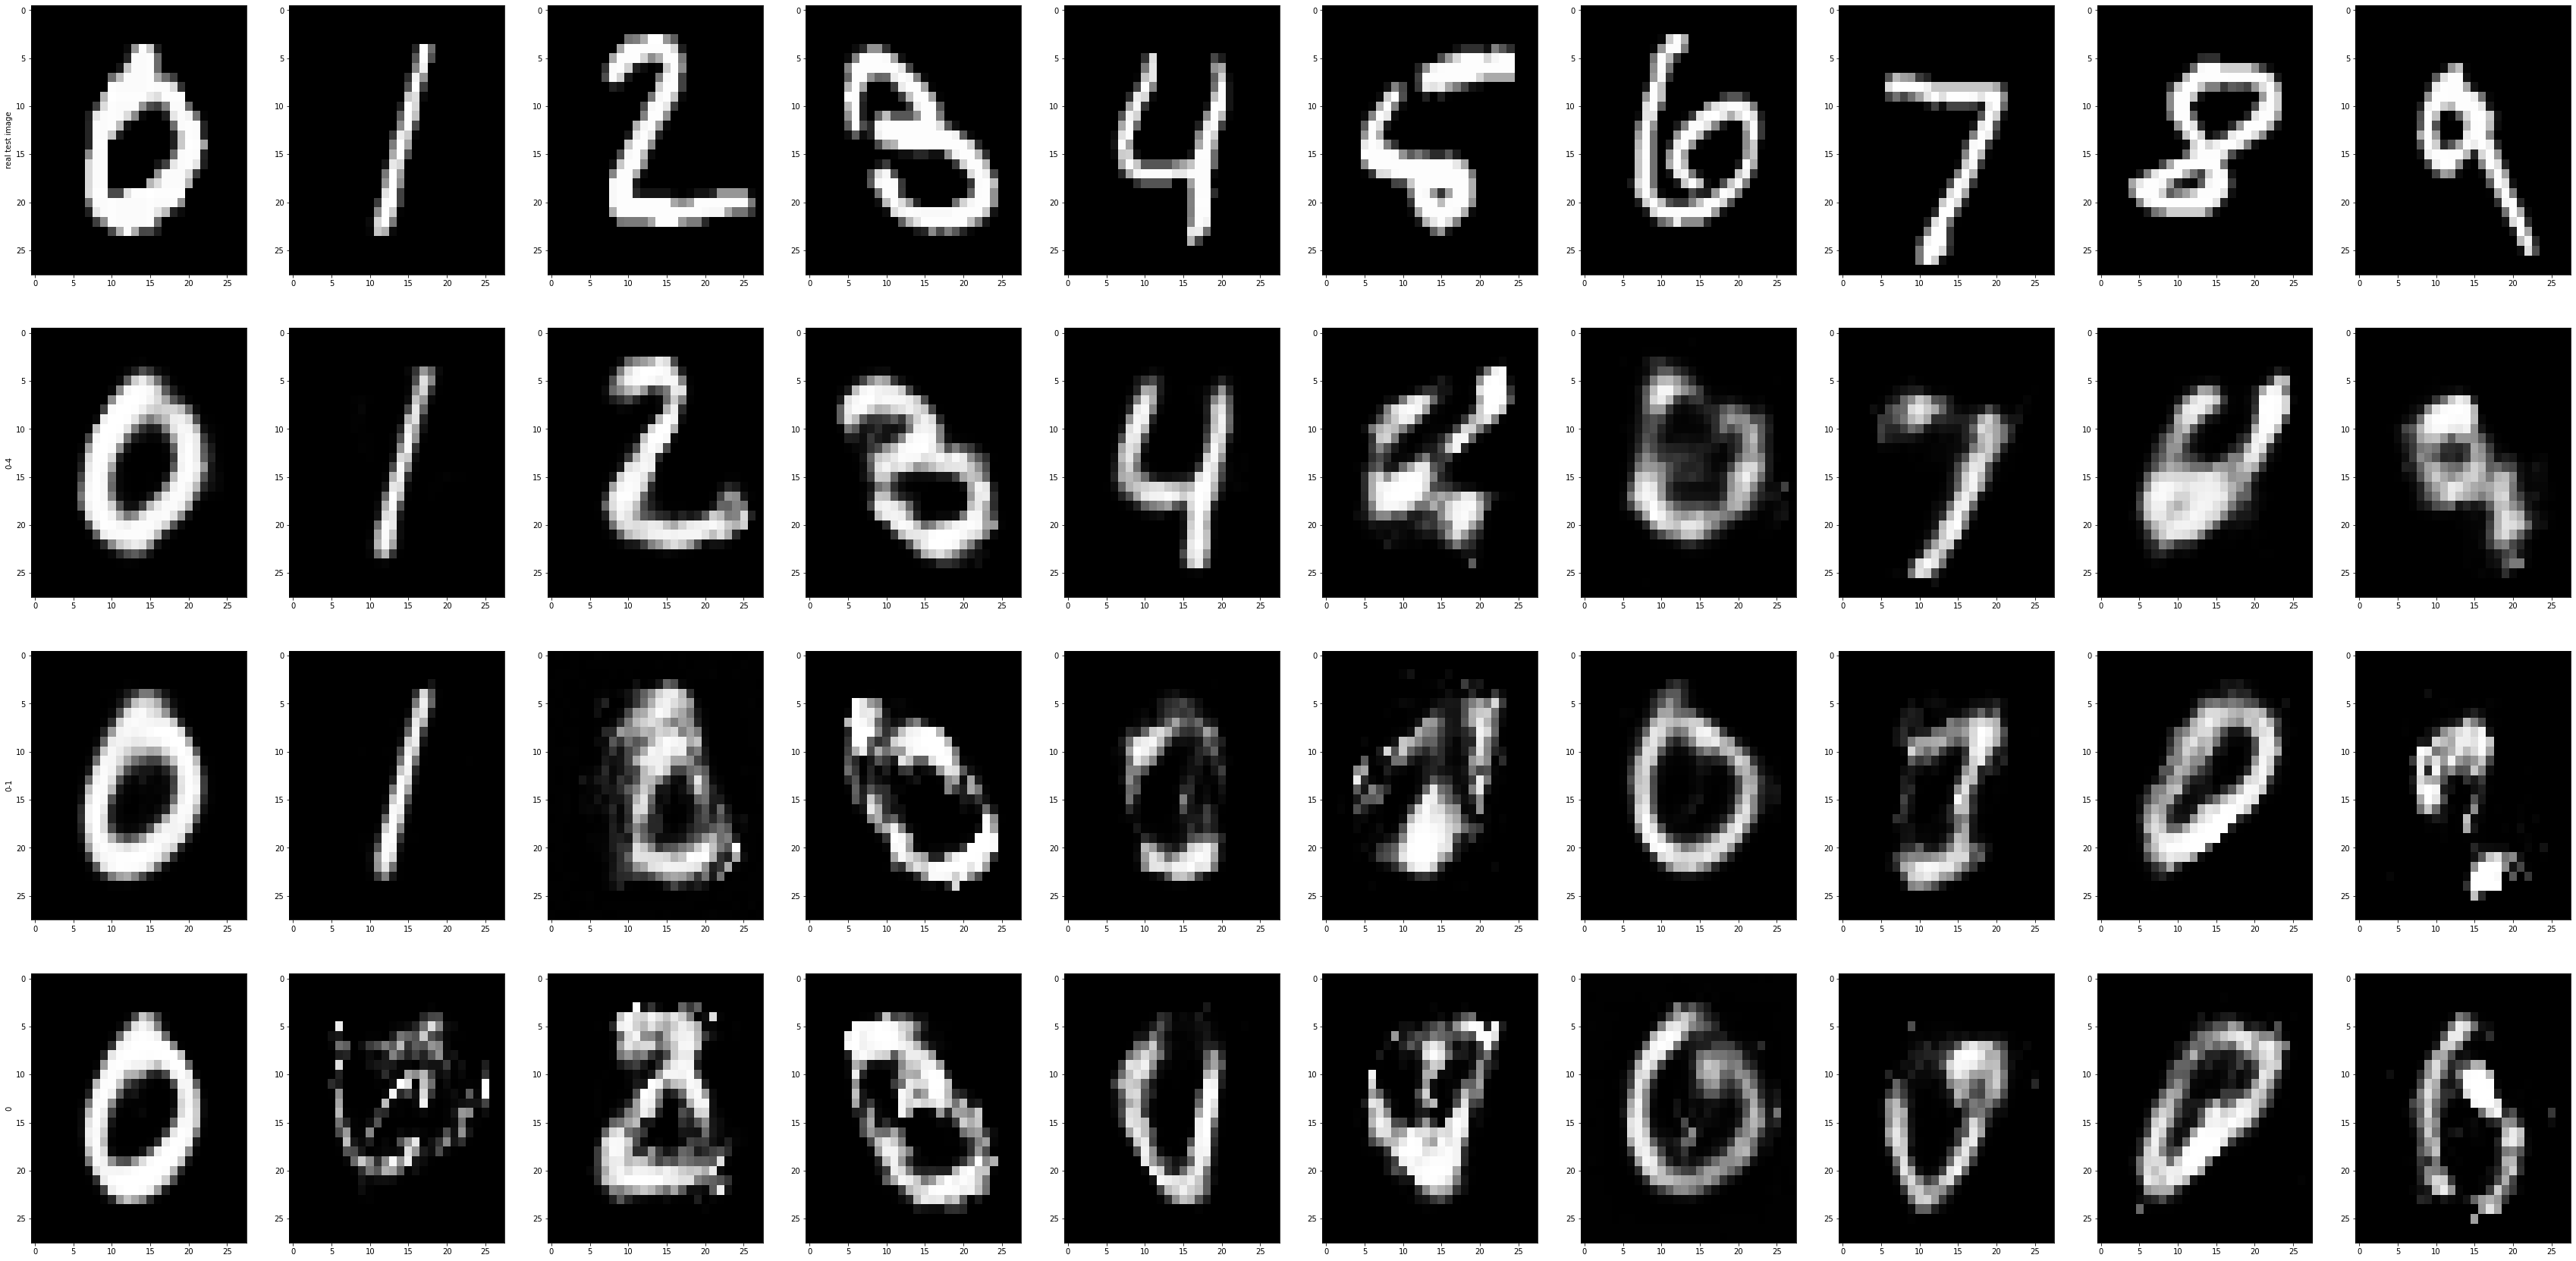

In [16]:
# visualization
fig, axs =  plt.subplots(len(anomaly_model_dict.keys()) + 1, 10, figsize=(60, 30))
axs[0][0].set_ylabel("real test image")
for i in range(10):
    axs[0][i].imshow(anomaly_model_dict["0"].test_dataset_dict[i][0][0].view(28, 28).numpy(), cmap='gray', aspect = "auto")

for idx, (name, methods) in enumerate(anomaly_model_dict.items()):
    for i in range(10):
        with torch.no_grad() :
            axs[idx+1][0].set_ylabel(name)
            data, _ = methods.test_dataset_dict[i][0]
            data = data.view(-1, 784)
            _, decoded = methods.model(data)
            axs[idx+1][i].imshow(decoded.view(28, 28).numpy(), cmap='gray', aspect = "auto")


- 학습시킨 정상 데이터에 대해서 각 모델들이 제대로 복원하고 있는 모습을 보이고 있다. 
- 반대로 학습 시 반영되지 않은 비정상 데이터에 대해 모델들이 제대로 복원하지 못하는 모습을 보인다. 
- 특히 비정상 데이터 중 정상 데이터와 형태가 비슷한 데이터가 존재할 경우 (대부분의 숫자 2 ~ 9는 곡선을 가지고 있어 0과 비슷하다.) 정상 데이터의 형태로 복원하는 모습을 보이고 있다. 
- 정상 데이터의 분포가 좁아 질수록 입력 데이터(첫번째 행)과 복원된 이미지의 형태(1 ~ 3번째 행)가 달라지는 모습을 볼 수 있다. 

### 2-4. AUROC 계산 

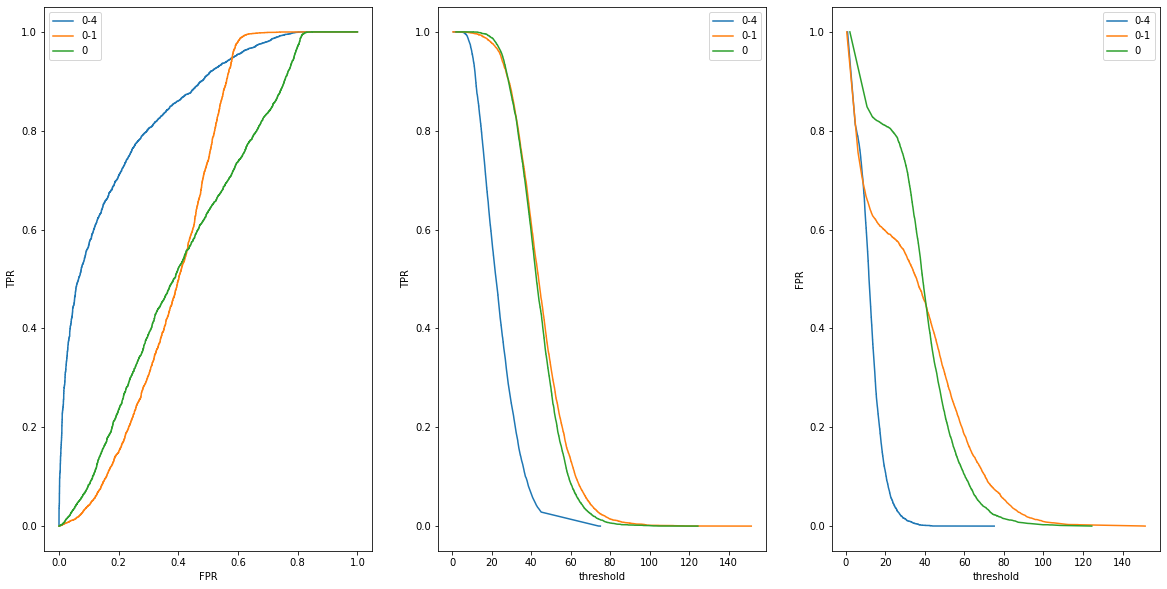

In [17]:
## calculate AUROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

TestDataset = anomaly_model_dict["0"].test_dataset
anomaly_targets = [1 if label.item() in {5, 6, 7, 8, 9} else 0 for label in TestDataset.targets] # 0: abnormal, 1: normal

anomaly_score_dict = {}
for name, model in anomaly_model_dict.items():
    anomaly_score_dict[name] = model.infer_anomaly_score()

fig, axs =  plt.subplots(1, 3, figsize=(20, 10))
for name, score in anomaly_score_dict.items():
    fpr, tpr, thresholds = roc_curve(anomaly_targets, [item for batch in score for item in batch])
    axs[0].plot(fpr, tpr, label=name)
    axs[1].plot(thresholds, tpr, label=name)
    axs[2].plot(thresholds, fpr, label=name)

axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].legend()
axs[1].set_xlabel("threshold")
axs[1].set_ylabel("TPR")
axs[1].legend()
axs[2].set_xlabel("threshold")
axs[2].set_ylabel("FPR")
axs[2].legend()

In [18]:
for name, model in anomaly_model_dict.items():
    print("방법론 : ", f"{name:<20}", "AUROC 성능 : ", roc_auc_score(anomaly_targets, [item for batch in model.infer_anomaly_score() for item in batch]))

방법론 :  0-4                  AUROC 성능 :  0.8436534891625643
방법론 :  0-1                  AUROC 성능 :  0.6214532038940975
방법론 :  0                    AUROC 성능 :  0.5911100334782734


만약 정상 데이터를 제대로 정의하지 못한다면, Anomaly Detection 태스크에서 성능이 제대로 나오지 못하는 것은 자명하다. 이는 위 실험에서도 명확히 보여지고 있다. 실제 정상 데이터 클래스가 0, 1, 2, 3, 4일 때, 각각 정상 데이터를 0으로만 학습한 경우(녹색), 0과 1로 학습한 경우(주황색), 0 ~ 4로 학습한 경우(파랑색)을 살펴보면, 오직 정상 데이터를 제대로 정의한 파란색의 경우에만, AUROC 커브가 제대로 그려진 것을 확인할 수 있다. 또한, 제대로 정의가 되지 못한 경우에도, Threhold를 높이면, TPR을 높일 수 있다는 점은 주목할만하다. 상황에 따라, False Positive 혹은 False Negative가 중요할 수 있기 때문에, 정상 데이터의 범위를 넓게 잡을 지 좁게 잡을 지 선택할 수 있다는 점을 보여주고 있다. 즉, 아래와 같은 결론을 내릴 수 있다. 

- False Positive를 줄이고 싶다면, 정상 데이터를 최대한 많이 확보해야 한다. 만약, 제대로 정상 데이터의 분포를 모델이 학습하지 못한다면, Threshold와 관계없이 FPR이 높아질 수 있기 때문이다. 
- False Negaive를 줄이고 싶다면, 정상 데이터를 비록 제대로 확보하지 못하여도, 큰 문제가 되지 않을 수 있다. 왜냐하면 FPR이 중요하지 않기 때문에, Threhold를 낮춰, FPR이 높아지더라도 TPR을 높일 수 있기 때문이다.

# 3. Anomaly Detection 실험 2 : 모델 구조 별 Anomaly Detection 성능 변화 관찰 

다음으로 1번 실험에서 살펴보았던 모델들의 Anomaly Detection 시 성능을 살펴보도록 하자. 이때 주의깊게 살펴볼 점은 Anomaly Detection 성능이, 학습 데이터에 대한 복원 성능과 일치하는지가 중요하다. 이 두 요소가 일치해야, 실제로 AutoEncoder가 Anomaly Detection에 사용될 때, 정상 이미지를 복원하는 능력이 중요하다는 점을 알 수 있기 때문이다. 

In [19]:
anomaly_exp2_trainer_dict = {}

### 3-1. 단순 AutoEncoder

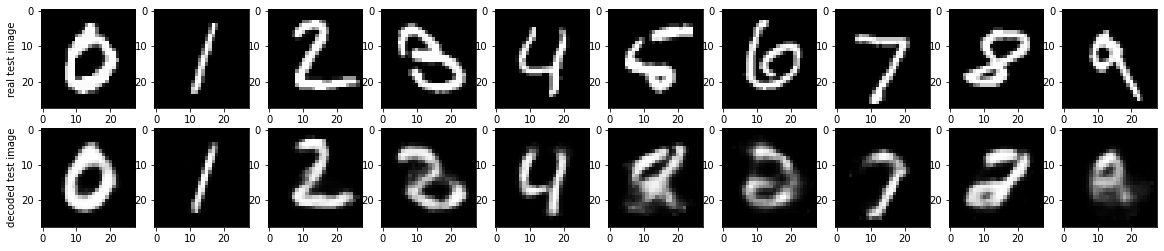

In [20]:
model_args = ModelArgs()
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_half = Trainer(model_args, train_args, data_args)
trainer_anomaly_half.train()
trainer_anomaly_half.visualize()
anomaly_exp2_trainer_dict["base"] = trainer_anomaly_half

## 3-2. Shallow AutoEncoder

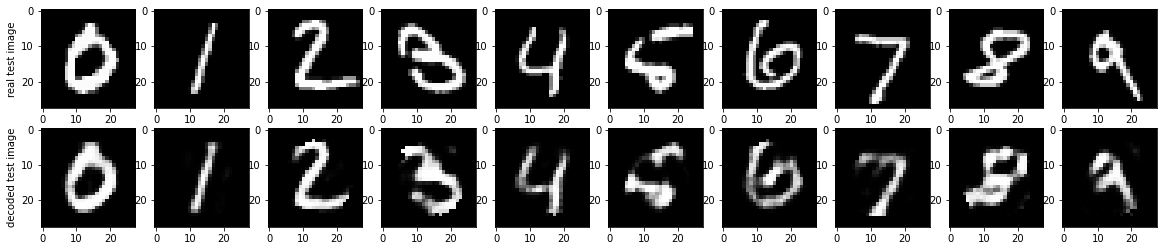

In [21]:
model_args = ModelArgs()
model_args.hidden_sizes = [784, 64]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_base = Trainer(model_args, train_args, data_args)
trainer_anomaly_base.train()
trainer_anomaly_base.visualize()
anomaly_exp2_trainer_dict["shallow"] = trainer_anomaly_base

### 3-2. Denoising AutoEncoder(noise 강도: 0.1)

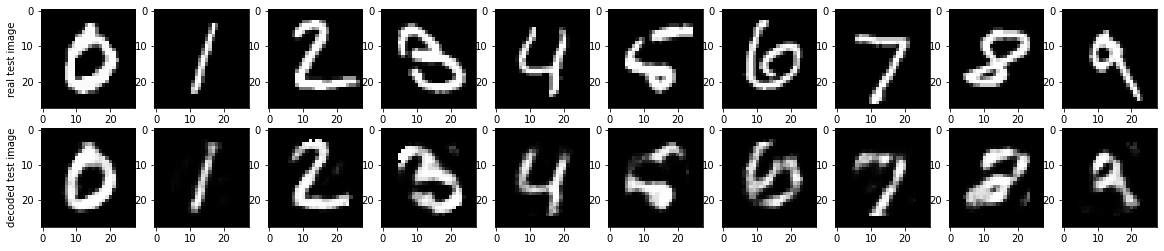

In [22]:
model_args = ModelArgs()
model_args.add_gaussian_noise = True
model_args.hidden_sizes = [784, 64]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_denoise0_1 = Trainer(model_args, train_args, data_args)
trainer_anomaly_denoise0_1.train()
trainer_anomaly_denoise0_1.visualize()
anomaly_exp2_trainer_dict["denoise0_1"] = trainer_anomaly_denoise0_1

### 3-3. Denoising AutoEncoder(noise 강도 : 0.01)

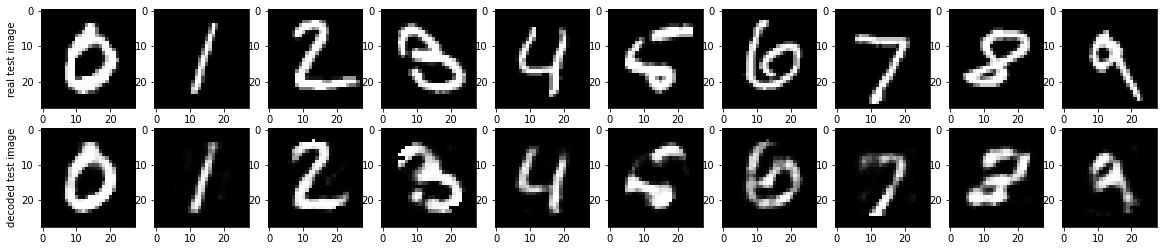

In [23]:
model_args = ModelArgs()
model_args.add_gaussian_noise = True
model_args.gaussian_noise_mag = 0.01
model_args.hidden_sizes = [784, 64]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_denoise0_01 = Trainer(model_args, train_args, data_args)
trainer_anomaly_denoise0_01.train()
trainer_anomaly_denoise0_01.visualize()
anomaly_exp2_trainer_dict["denoise0_01"] = trainer_anomaly_denoise0_01

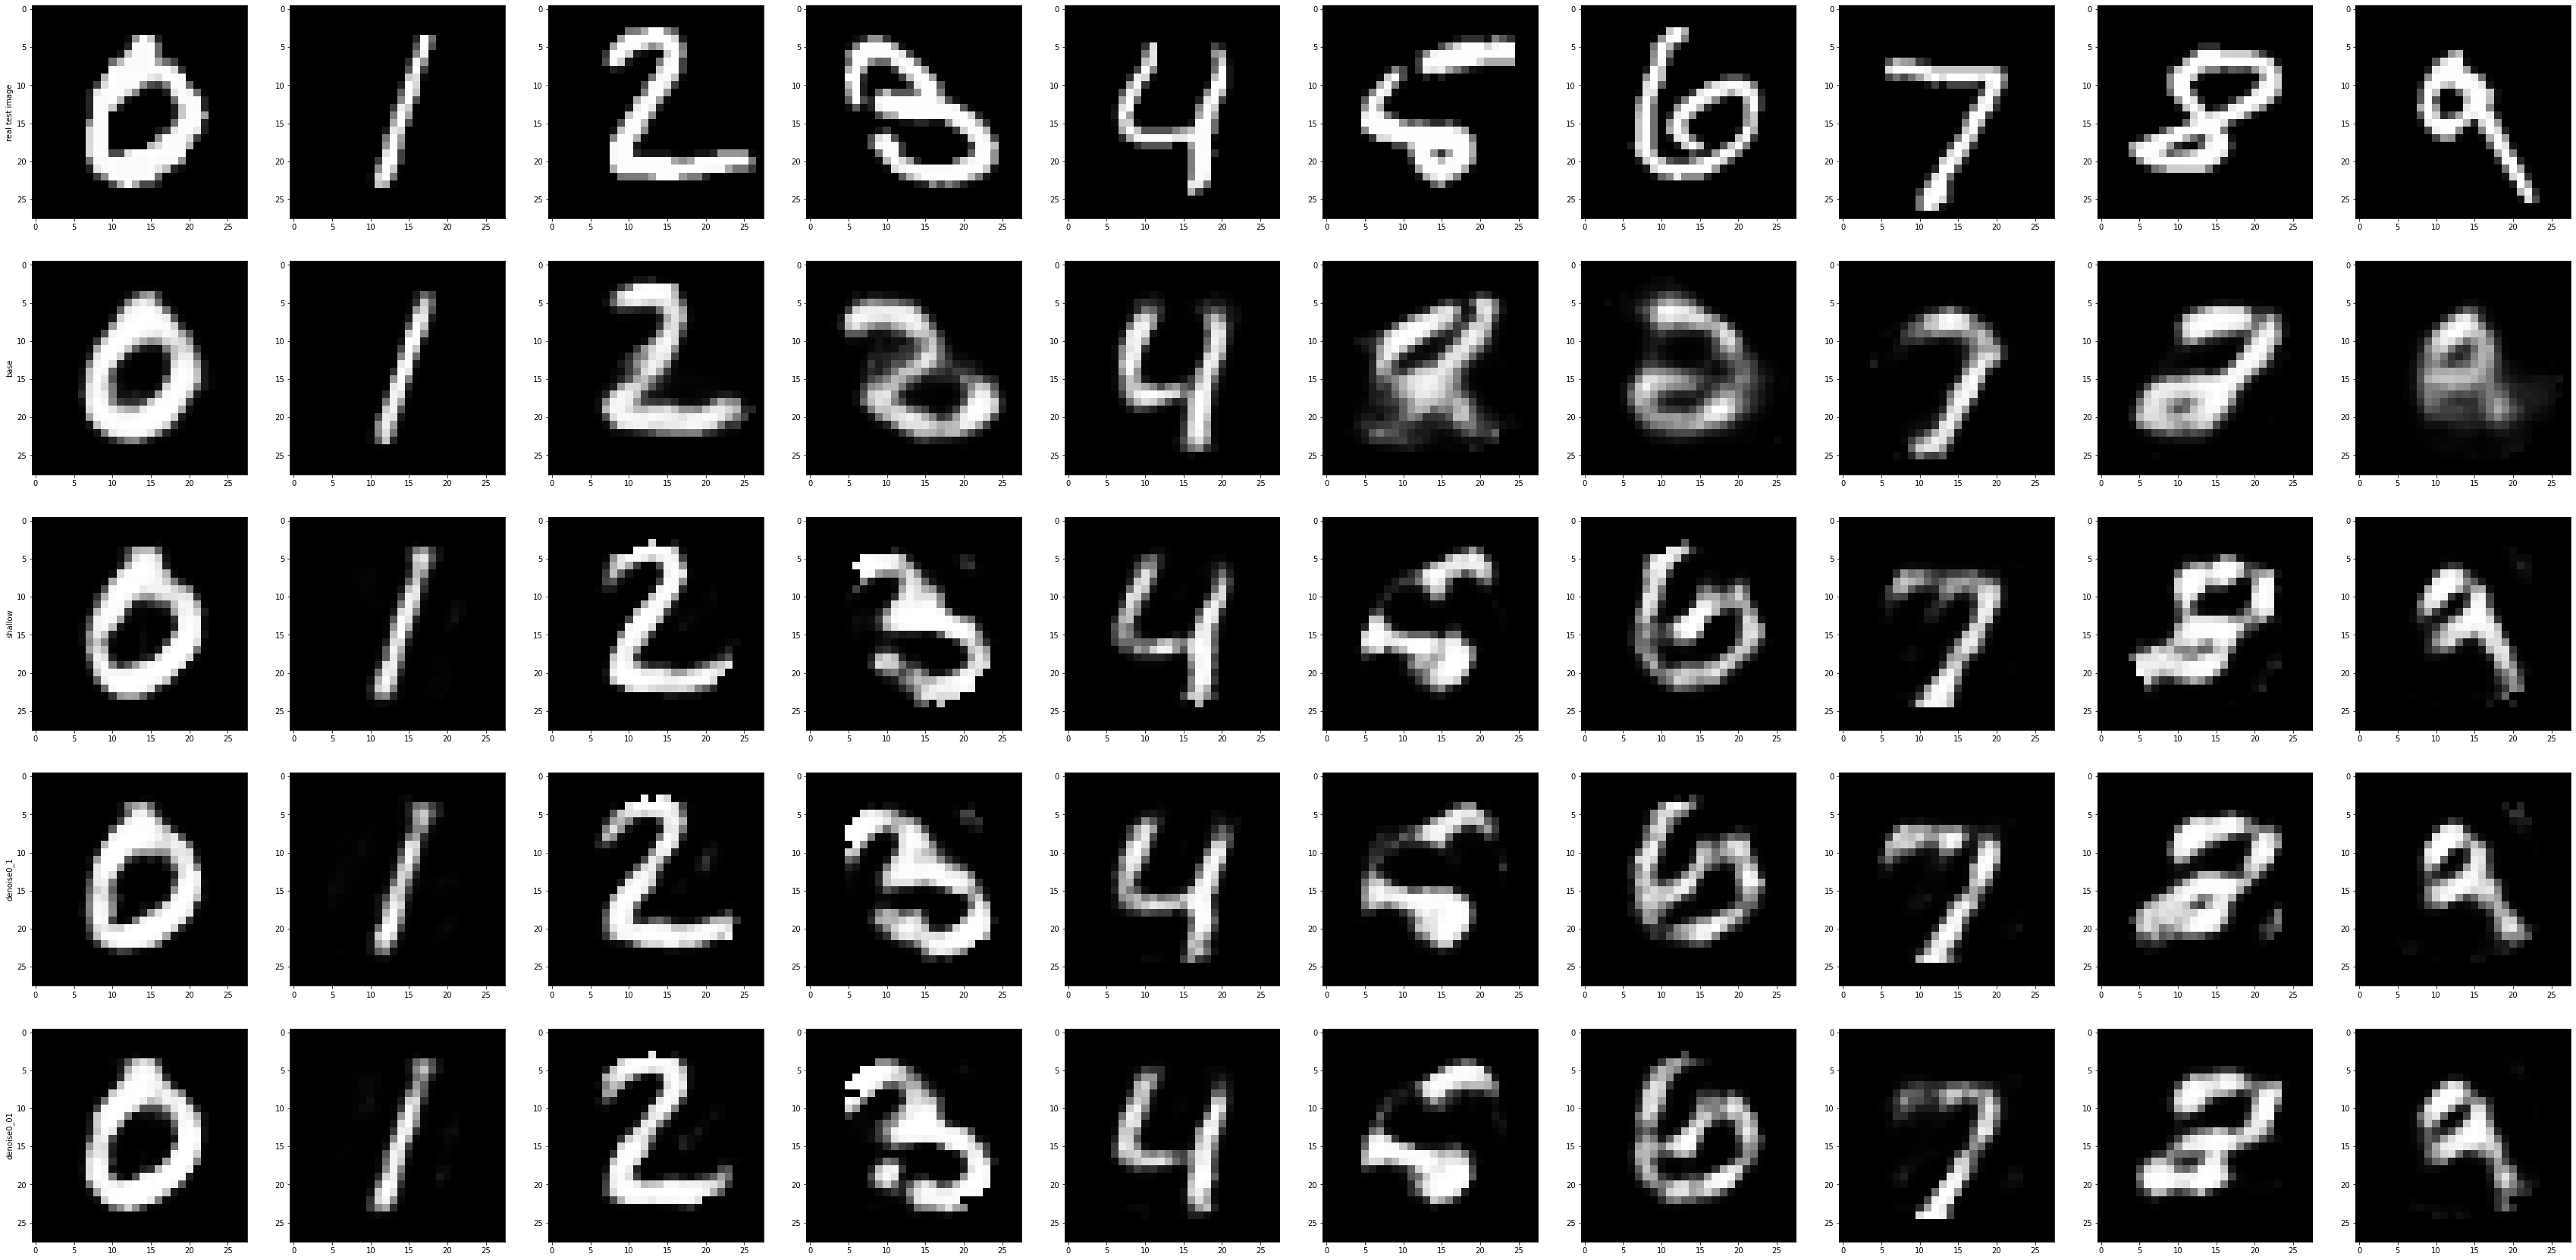

In [24]:
# visualization
fig, axs =  plt.subplots(len(anomaly_exp2_trainer_dict.keys()) + 1, 10, figsize=(60, 30))
axs[0][0].set_ylabel("real test image")
for i in range(10):
    axs[0][i].imshow(anomaly_exp2_trainer_dict["denoise0_01"].test_dataset_dict[i][0][0].view(28, 28).numpy(), cmap='gray', aspect = "auto")

for idx, (name, methods) in enumerate(anomaly_exp2_trainer_dict.items()):
    for i in range(10):
        with torch.no_grad() :
            axs[idx+1][0].set_ylabel(name)
            data, _ = methods.test_dataset_dict[i][0]
            data = data.view(-1, 784)
            _, decoded = methods.model(data)
            axs[idx+1][i].imshow(decoded.view(28, 28).numpy(), cmap='gray', aspect = "auto")


놀랍게도 Shallow Layer 기반의 모델들은 학습 시점에서 등장하지 않은 5, 6, 7, 8, 9에 대해서도 어느 정도 복원을 해내는 모습을 나타내고 있다. 이는 Shallow Layer 기반의 모델들이 비교적 적은 파라미터 수로 학습하면서 해당 태스크 및 데이터 셋 크기에 적절한 학습이 되었음을 의미한다. 즉, 적절할 파라미터 수를 가지고 있기 때문에, 학습 시점에 등장하지 않은 이미지들 역시 충분히 학습되고 있음을 보여준다. 이와 대조적으로 마지막 행에 해당하는 Hidden Layer가 2개의 AutoEncoder의 경우 학습 시점에 등장하지 않은 클래스의 이미지들은 잘 복원하지 못하는 모습을 보여준다. 이는 파라미터 수가 많아지면서 학습 시점의 데이터에 어느 정도 과적합이 발생했다고 볼 수 있다.

일반화 성능은 일반적인 태스크에서 매우 중요한 성질이지만, Anomaly Detection의 경우 모델의 일반화 성능이 너무 높을 경우 Anomaly 역시 학습 데이터라고 판정할 우려가 있다. 즉, 학습 데이터 분포와 다른 분포에 대해 제대로 복원하지 못하는 것이 Anomaly Detection 모델에서 중요한 성질임을 고려하면, 오히려 일부 과적합이 발생한 Base 모델이 더욱 적합하다고 할 수 있다. 

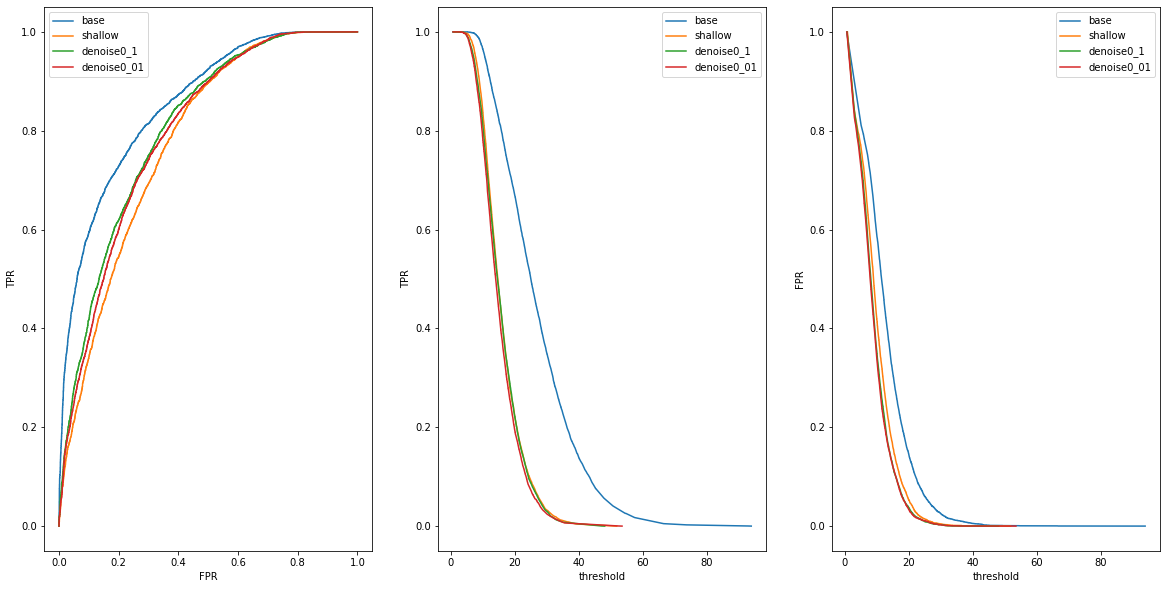

In [25]:
## calculate AUROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

TestDataset = anomaly_exp2_trainer_dict["base"].test_dataset
anomaly_targets = [1 if label.item() in {5, 6, 7, 8, 9} else 0 for label in TestDataset.targets] # 0: abnormal, 1: normal

anomaly_score_dict = {}
for name, model in anomaly_exp2_trainer_dict.items():
    anomaly_score_dict[name] = model.infer_anomaly_score()

fig, axs =  plt.subplots(1, 3, figsize=(20, 10))
for name, score in anomaly_score_dict.items():
    fpr, tpr, thresholds = roc_curve(anomaly_targets, [item for batch in score for item in batch])
    axs[0].plot(fpr, tpr, label=name)
    axs[1].plot(thresholds, tpr, label=name)
    axs[2].plot(thresholds, fpr, label=name)

axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].legend()
axs[1].set_xlabel("threshold")
axs[1].set_ylabel("TPR")
axs[1].legend()
axs[2].set_xlabel("threshold")
axs[2].set_ylabel("FPR")
axs[2].legend()

In [26]:
for name, model in anomaly_exp2_trainer_dict.items():
    print("방법론 :", f"{name:<20}", "AUROC 성능 : ", roc_auc_score(anomaly_targets, [item for batch in model.infer_anomaly_score() for item in batch]))

방법론 : base                 AUROC 성능 :  0.8543923085517411
방법론 : shallow              AUROC 성능 :  0.7782305877274193
방법론 : denoise0_1           AUROC 성능 :  0.8046667386422923
방법론 : denoise0_01          AUROC 성능 :  0.7959486809786075


위 시각화 자료에서 해석한 결과는 실제 성능으로도 나타나고 있다. Base 모델이 가장 바깥쪽에서 ROC Curve를 그리고 있다. 또한, Threshold 별 TPR을 보여주는 가운데 Plot을 살펴보면, Shallow 기반의 모델들은 아직 Base 모델이 TPR이 0 이 아닌 시점 (Threshold=40 부근)에서 이미 TPR이 0에 가까워진 모습을 보인다.

이러한 경향은 AUROC에서 확연히 들어난다. Denoising 여부가 성능에 미치는 영향보다, Shallow vs Deep 여부가 성능에 더 큰 영향을 미친다. 이는 1번 실험에서 보았던, **복원 성능과 실제 Anomaly Detection 성능이 일치하지 않을 수 있다**는 결과를 의미한다. 이를 조금 더 살펴보도록 하자. 

# 4. Network Depth 별 Anomaly Detection 성능 비교

In [27]:
anomaly_exp3_trainer_dict = {}

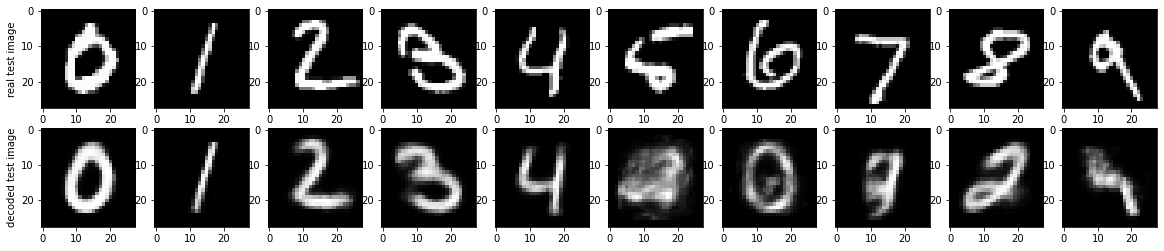

In [28]:
model_args = ModelArgs()
model_args.hidden_sizes = [784, 512, 256, 64, 32]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_depth_4 = Trainer(model_args, train_args, data_args)
trainer_anomaly_depth_4.train()
trainer_anomaly_depth_4.visualize()
anomaly_exp3_trainer_dict["depth_4"] = trainer_anomaly_depth_4

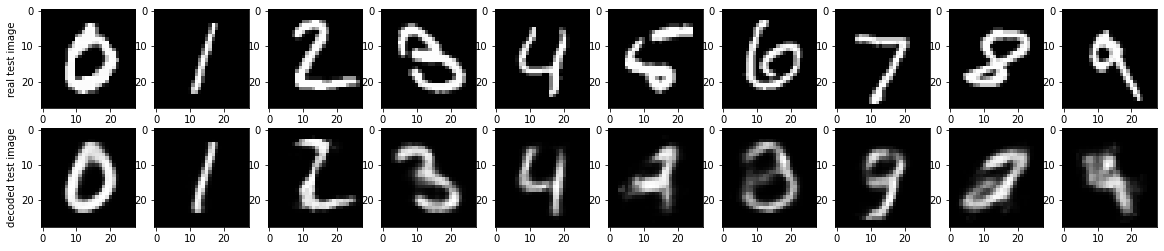

In [31]:
model_args = ModelArgs()
model_args.hidden_sizes = [784, 512, 256, 32]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_depth_3 = Trainer(model_args, train_args, data_args)
trainer_anomaly_depth_3.train()
trainer_anomaly_depth_3.visualize()
anomaly_exp3_trainer_dict["depth_3"] = trainer_anomaly_depth_3

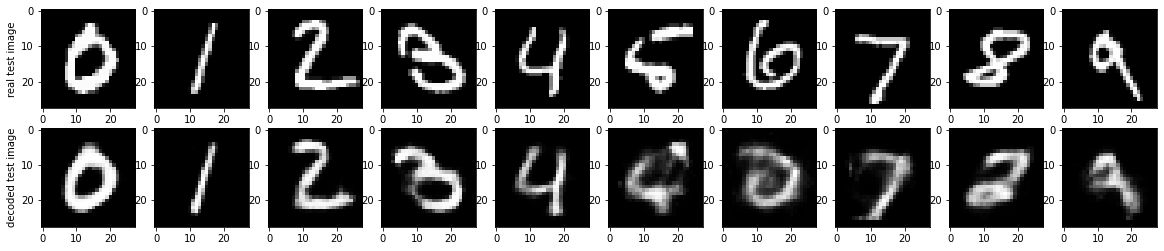

In [32]:
model_args = ModelArgs()
model_args.hidden_sizes = [784, 512, 32]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_depth_2 = Trainer(model_args, train_args, data_args)
trainer_anomaly_depth_2.train()
trainer_anomaly_depth_2.visualize()
anomaly_exp3_trainer_dict["depth_2"] = trainer_anomaly_depth_2

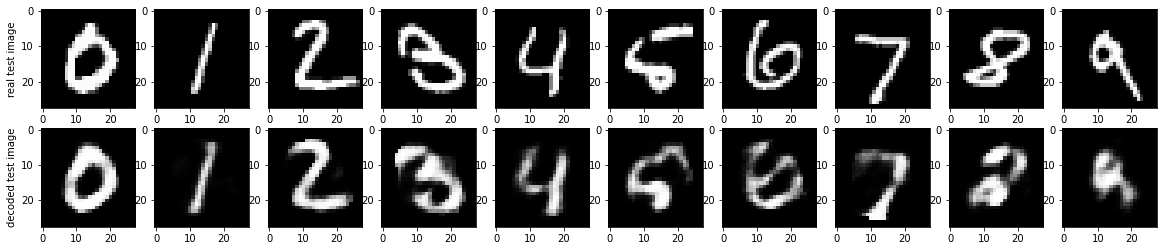

In [33]:
model_args = ModelArgs()
model_args.hidden_sizes = [784, 32]
train_args = TrainArgs()
data_args = DataArgs()
trainer_anomaly_depth_1 = Trainer(model_args, train_args, data_args)
trainer_anomaly_depth_1.train()
trainer_anomaly_depth_1.visualize()
anomaly_exp3_trainer_dict["depth_1"] = trainer_anomaly_depth_1

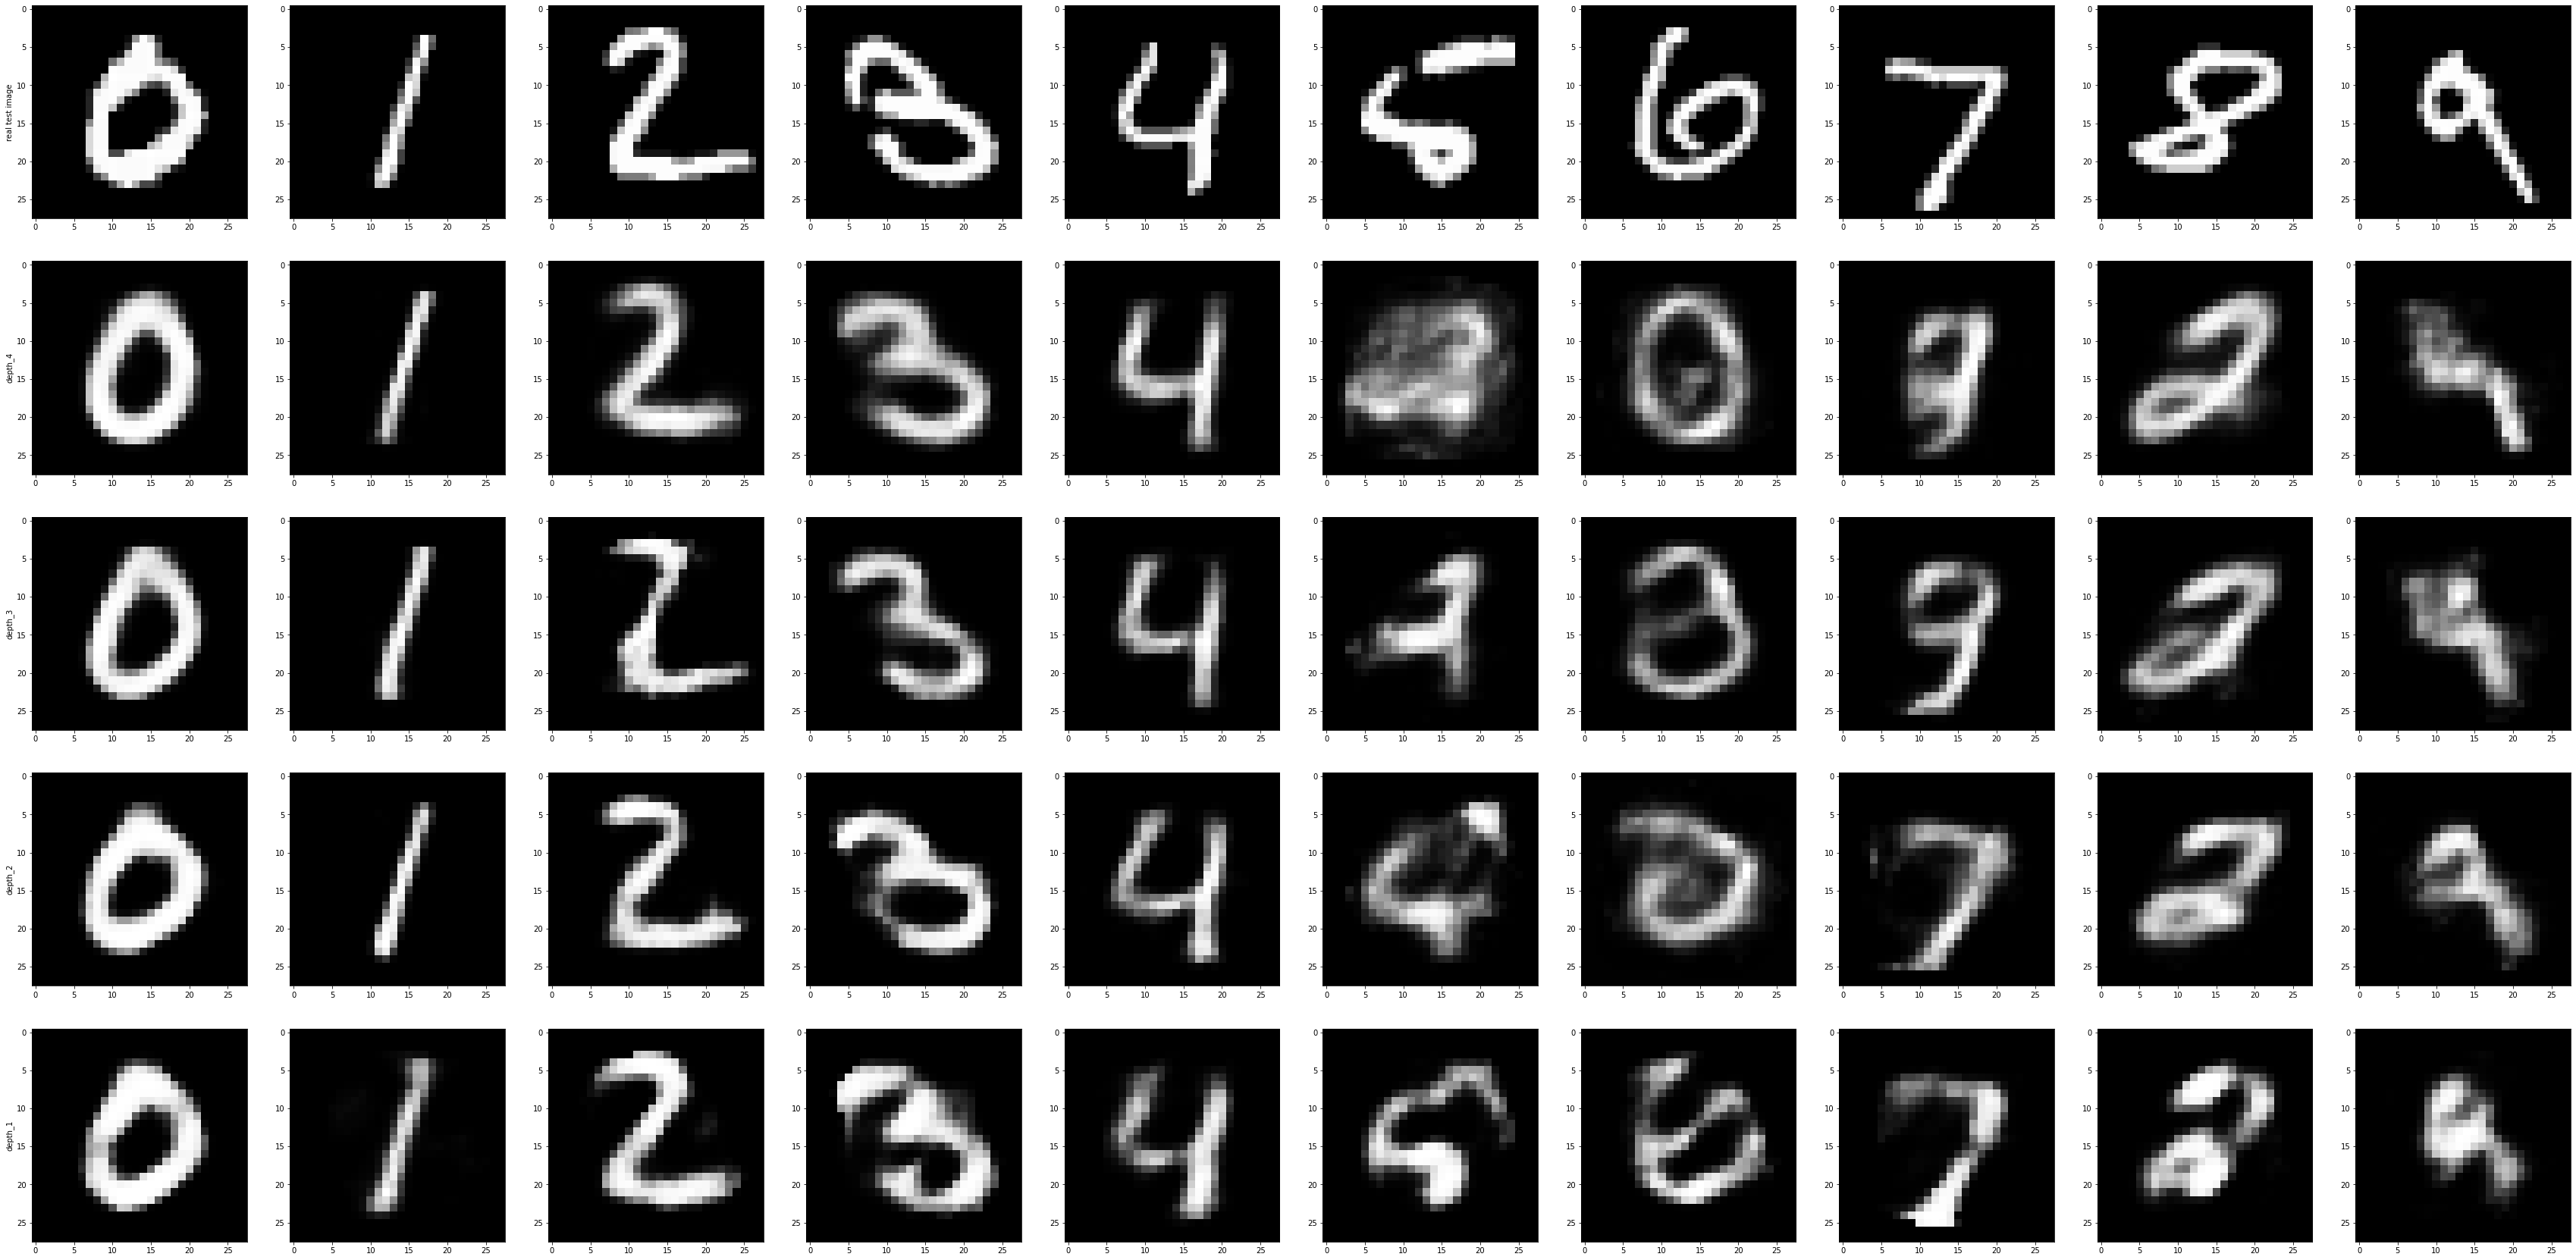

In [35]:
# visualization
fig, axs =  plt.subplots(len(anomaly_exp3_trainer_dict.keys()) + 1, 10, figsize=(60, 30))
axs[0][0].set_ylabel("real test image")
for i in range(10):
    axs[0][i].imshow(anomaly_exp3_trainer_dict["depth_1"].test_dataset_dict[i][0][0].view(28, 28).numpy(), cmap='gray', aspect = "auto")

for idx, (name, methods) in enumerate(anomaly_exp3_trainer_dict.items()):
    for i in range(10):
        with torch.no_grad() :
            axs[idx+1][0].set_ylabel(name)
            data, _ = methods.test_dataset_dict[i][0]
            data = data.view(-1, 784)
            _, decoded = methods.model(data)
            axs[idx+1][i].imshow(decoded.view(28, 28).numpy(), cmap='gray', aspect = "auto")


위 이미지는 동일 hidden representation 차원을 가지면서 다른 Hidden Layer 갯수를 가지는 모델 간 복원 이미지 결과이다. 첫번째 행의 원본 이미지를 각 모델이 복원한 수준을 정성적으로 확인해보자. 
- 우선, 레이어가 4개인 두번째 행의 경우 비정상 클래스(5, 6, 7, 8, 9) 이미지에 대해 제대로 복원하지 못하는 모습을 보이고 있다. 원본 이미지가 어떠한 숫자인지 파악하기 힘들다. 특히 6에 대해 정상 데이터였던 0으로 복원해내는 모습을 보이고 있다. 
- 레이어 수가 줄어들 수록 비정상 데이터에 대해서도 점차 복원이 가능해지는 모습을 볼 수 있다. 특히, 7의 경우 레이어 수가 3, 4개 일때는 전혀 복원하지 못했지만, 레이어 수가 2개 혹은 1개인 경우 어느 정도 복원된 모습을 보여준다. 또한, 6의 경우에도 레이어 수가 1개인 경우에는 옳바른 방향으로 6의 대략적 윤곽이 형성된 것을 볼 수 있다. 
- 이는 이전 실험에서 레이어 수가 많아지면서 파라미터가 많아져, 학습 데이터에 과적합 된다는 직관과 일치하는 결론이라 할 수 있다. 

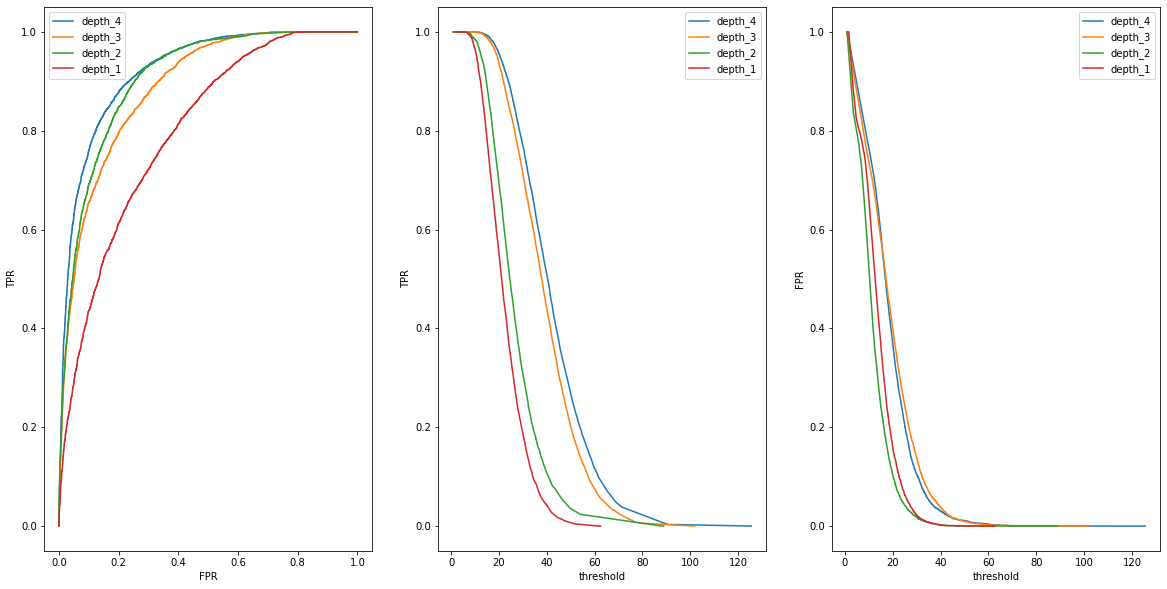

In [36]:
## calculate AUROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

TestDataset = anomaly_exp3_trainer_dict["depth_2"].test_dataset
anomaly_targets = [1 if label.item() in {5, 6, 7, 8, 9} else 0 for label in TestDataset.targets] # 0: abnormal, 1: normal

anomaly_score_dict = {}
for name, model in anomaly_exp3_trainer_dict.items():
    anomaly_score_dict[name] = model.infer_anomaly_score()

fig, axs =  plt.subplots(1, 3, figsize=(20, 10))
for name, score in anomaly_score_dict.items():
    fpr, tpr, thresholds = roc_curve(anomaly_targets, [item for batch in score for item in batch])
    axs[0].plot(fpr, tpr, label=name)
    axs[1].plot(thresholds, tpr, label=name)
    axs[2].plot(thresholds, fpr, label=name)

axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].legend()
axs[1].set_xlabel("threshold")
axs[1].set_ylabel("TPR")
axs[1].legend()
axs[2].set_xlabel("threshold")
axs[2].set_ylabel("FPR")
axs[2].legend()

In [40]:
for name, model in anomaly_exp3_trainer_dict.items():
    print("방법론 :", f"{name:<20}", "AUROC 성능 : ", roc_auc_score(anomaly_targets, [item for batch in model.infer_anomaly_score() for item in batch]), "복원 loss : ", model.final_test_loss.item())

방법론 : depth_4              AUROC 성능 :  0.9209352956338777 복원 loss :  0.0005873642512597144
방법론 : depth_3              AUROC 성능 :  0.8874348851766598 복원 loss :  0.0005649435333907604
방법론 : depth_2              AUROC 성능 :  0.9058231363526988 복원 loss :  0.0003735075588338077
방법론 : depth_1              AUROC 성능 :  0.796466160907796 복원 loss :  0.0003531945403665304


위 실험은 Hidden Representation의 차원을 통일하고 중간 레이어의 갯수를 조절하여 AUROC 및 복원 loss를 측정한 결과이다. 위 실험에서 AUROC는 클 수록 Anomaly Detection 성능이 좋다는 의미이고, 복원 loss가 낮을 수록 원본 이미지를 잘 복원한다는 의미이다. 두가지 결과를 종합하면 다음과 같은 최종 결론에 이를 수 있다. 

- 복원 성능과 Anomaly Detection 성능은 일치하지 않을 수 있다. 
- 이는 AutoEncoder의 레이어 갯수 및 파라미터 수와 밀접한 관련이 있다. 
- MNIST와 같은 단순한 데이터의 경우 적절한 파라미터 수를 가진 모델이 매우 높은 일반화 성능을 보이기도 한다. 그로 인해 depth_1일 때와 같이 학습 시점에 보지 못한 숫자들에 대해서도 일부 복원이 가능한 것을 알 수 있다. 
- 하지만 이와 같은 높은 일반화 성능은 Anomaly Detection에 있어 좋지 못하다. AUROC에서 알 수 있듯이, 높은 복원 성능은 정상 데이터에 대한 너무 넓은 정의로 이어진다. 이로인해 비정상 데이터 조차 정상 데이터로 분류될 가능성이 높아지게 된다. 
- Anomaly Detection 태스크 수행 시 적절한 일반화 성능을 통해 정상 데이터의 범위를 조절하고, 이상치 점수를 합리적으로 산출할 수 있는 모델이 적절하다. 



위와 같은 결론은 딥러닝 모델의 한계점으로 인해 발생한 현상일 수 있다. SVDD와 같은 통계 기반 방법론의 경우 정상 데이터의 HyperSphere를 설정하는 등의 Loss 설계를 통해 자연스럽게 모델이 정상 데이터의 범주를 조절할 수 있도록 한다. 하지만 해당 실험들의 AutoEncoder 모델은 모두 MSE Loss를 사용하고 있기 때문에, 정상 데이터의 HyperSphere에 대한 제약이 존재하지 않는다. 이로인해 일반화 성능과 Anomaly Detection 성능이 일치하지 않는 결과가 발생한 것일 수 있다. 